In [5]:
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics.pairwise import euclidean_distances

In [6]:
from net_utils import *

In [7]:
circle = np.array([[np.cos(x),np.sin(x)] for x in np.random.rand(100)*2*np.pi])
X, Y = make_blobs(n_samples=70, centers=circle, n_features=2,
                 random_state=0,cluster_std =0.1)
r = np.random.uniform(-2,2,(200,2))
lr = (np.min(euclidean_distances(circle,r),axis = 0)>0.1)*1.
Xtrain = np.concatenate((r,X))
Ytrain = np.concatenate((lr,np.zeros(70))).astype(float)
Xtrain.shape,Ytrain.shape
Ytrain = Ytrain.reshape(-1,1)
Ytrain.shape
t = np.linspace(-2, 2,100, endpoint=False)
T = np.zeros((10100,2))
a=0
for i in t:
    for j in t:
        T[a]=np.array([i,j])
        a+=1
    a+=1

In [11]:
criterion = F.binary_cross_entropy_with_logits
file_dataset = csvDataset(Xtrain,Ytrain,transform= ToTensor())
final_loader = torch.utils.data.DataLoader(file_dataset,batch_size=3, shuffle=True)
inference_dataset = csvDataset(T,np.zeros((10100,2)),transform= ToTensor())
inference_loader = torch.utils.data.DataLoader(inference_dataset,batch_size=10100, shuffle=False)

In [12]:
maxout_model = maxout_Net(10,5)
optimizer = Adam_bis(maxout_model.parameters(), prec = 4,weight_decay=0)
maxout_model ,train_accuracy_maxout,eval_n_maxout,weights_maxout = train_model_cc_fast(maxout_model, final_loader,inference_loader, criterion,
    optimizer,Xtrain.shape[0], num_epochs=200)

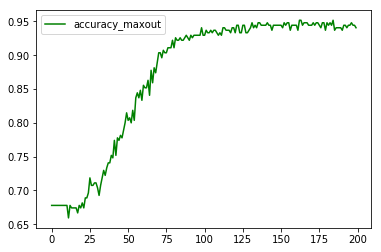

In [15]:
plt.plot(train_accuracy_maxout,label='accuracy_maxout',color='green')
plt.legend()

In [123]:
class Polynomial_Tropical_maxout_net:
    
    def __init__(self, poids,prec,pool_size):

        self.poids = poids
        self.pool_size = pool_size
        self.size = int(len(poids.values())/2)
        self.F=[]
        self.G=[]
        self.H=[]
        self.shapes=[2]
        self.prec = prec
        self.hyp = []

    def get_hypersurface(self,T):
        for i in range(T.shape[0]):
            self.generate_polynom(T[i])
            
    def trace_hypersurface(self):
        R = np.zeros((len(self.hyp),2))
        for i in range(len(self.hyp)):
            R[i]=self.hyp[i]
        plt.scatter(R[:, 0], R[:, 1], marker='o',s=25, edgecolor='k')       
    
    def stack_hypersurface(self):
        R = np.zeros((len(self.hyp),2))
        for i in range(len(self.hyp)):
            R[i]=self.hyp[i]
        return R
    
    def generate_polynom(self,x):
        
        state_f = x.reshape(-1,1)
        state_g = np.zeros((state_f.shape))
        state_h = np.zeros((state_f.shape))
        self.F.append(state_f)
        self.G.append(state_g)
        self.H.append(state_h)
        
        
        for i in range(1,self.size+1):
            
            W = self.poids['f'+str(i)+'.lin.weight']
            W_plus,W_moins = decompose(W)
            b = self.poids['f'+str(i)+'.lin.bias'].reshape(-1,1)
            
            p,k = W.shape
            
            p = int(p/self.pool_size)

            state_g_next = W_plus.dot(state_g) + W_moins.dot(state_f)
            state_h_next = W_plus.dot(state_f) + W_moins.dot(state_g)+b
            
            print(state_g_next.shape,'g')
            print(state_h_next.shape,'h')

            state_g_next = state_g_next.reshape(self.pool_size,p)
            state_h_next = state_h_next.reshape(self.pool_size,p)
            
            print(state_g_next.shape,'g')
            print(state_h_next.shape,'h')
            
            state_f_pre = state_h_next-state_g_next
            
            state_f_next = np.max(state_f_pre,axis=0)
            
            print(state_f_next.shape,'f')
            print(p,'p')
            
            for d in range(p):
                l = state_f_next[d]
                for k in range(self.pool_size):
                    a=0
                    if abs(l-state_f_pre[k,d])<self.prec:
                        a+=1
                        
                        
                if a > 1 :
                    self.hyp.append(x)
           

            state_g,state_h,state_f=state_g_next,state_h_next,state_f_next.reshape(-1,1)
            
            self.F.append(state_f)
            self.G.append(state_g)
            self.H.append(state_h)
            
            print(i , 'layer done')
            
        '''    
            
        W = self.poids['f'+str(self.size)+'.lin.weight']
        W_plus,W_moins = decompose(W)
        b = self.poids['f'+str(self.size)+'.lin.bias']
        state_g_next = W_plus.dot(state_g) + W_moins.dot(state_f)
        state_h_next = W_plus.dot(state_f) + W_moins.dot(state_g)
        
        ll = state_h_next+b-state_g_next
        #print(self.size , 'layer done')
        
        return ll
        '''

In [124]:
weights_maxout[0].keys()

dict_keys(['f1.lin.weight', 'f1.lin.bias', 'f2.lin.weight', 'f2.lin.bias'])

In [125]:
d = Polynomial_Tropical_maxout_net(weights_maxout[0],0.0008,5)
d.generate_polynom(np.array([1,1]))

(50, 1) g
(50, 1) h
(5, 10) g
(5, 10) h
(10,) f
10 p
1 layer done


ValueError: shapes (10,10) and (5,10) not aligned: 10 (dim 1) != 5 (dim 0)

In [126]:
np.max(a,axis=1).shape

(1, 3)

In [58]:
t = np.linspace(-2, 2,100, endpoint=False)
T = np.zeros((10100,2))
a=0
for i in t:
    for j in t:
        T[a]=np.array([i,j])
        a+=1
    a+=1

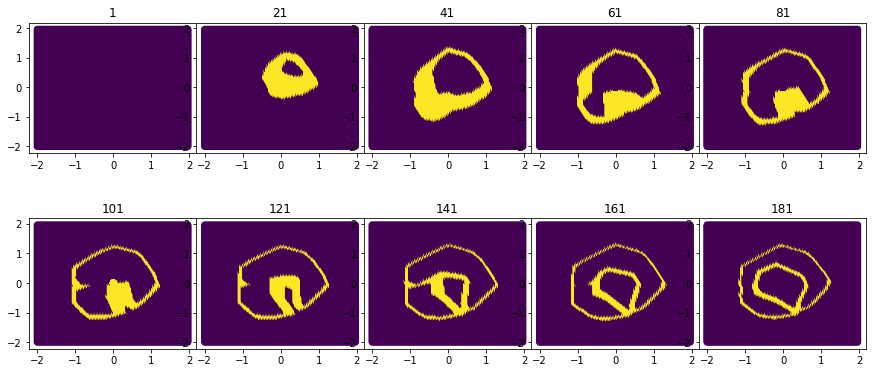

In [50]:
fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(10):
    rr = eval_n_maxout[i*20].reshape(10100)
    axs[i].scatter(T[:, 0], T[:, 1], c =rr)
    axs[i].set_title(str(1+i*20))

ValueError: shapes (10,10) and (50,) not aligned: 10 (dim 1) != 50 (dim 0)

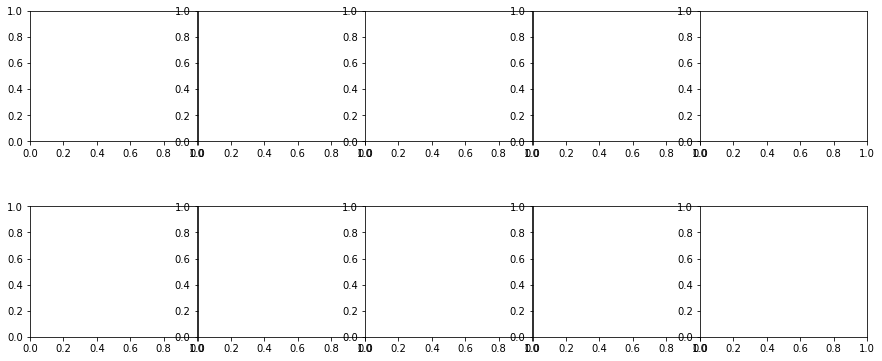

In [53]:
fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.003)

axs = axs.ravel()

for i in range(10):
    P = Polynomial_Tropical_maxout_net(weights_maxout[1+i*20],0.0008,5)
    P.get_hypersurface(T)
    R = P.stack_hypersurface()
    axs[i].scatter(R[:, 0], R[:, 1],marker='o',s=5, edgecolor='k')
    axs[i].set_title(str(1+i*20))